<a href="https://colab.research.google.com/github/cemdenizsel/Financial-Sentiment-Analysis-with-Transformer-Based-Models/blob/main/Test_51k_pretrain_with_FiQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq transformers

In [ ]:
import transformers

import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer
from sklearn import metrics


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!gdown --id 1IHOYSFpnlUDnVA7TB0Z-p9P1p9_PlTN1
!gdown --id 1F8ErtRfVn0NAdIdwfcneNaM8qZfo8hch

Downloading...
From: https://drive.google.com/uc?id=1IHOYSFpnlUDnVA7TB0Z-p9P1p9_PlTN1
To: /content/scores.txt
100% 3.12k/3.12k [00:00<00:00, 14.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F8ErtRfVn0NAdIdwfcneNaM8qZfo8hch
To: /content/sentences.txt
100% 27.6k/27.6k [00:00<00:00, 20.6MB/s]


In [ ]:
scores = pd.read_csv('scores.txt', sep='delimiter',names=["sentiment"] ,header = None )
sentences = pd.read_csv('sentences.txt',sep='delimiter',header = None, names=['sentences'])
df = pd.concat([sentences , scores], axis=1, join='inner')
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,sentences,sentiment
0,Royal Mail chairman Donald Brydon set to step ...,-0.374
1,Stakes High for AstraZeneca Heart Drug Facing ...,-0.240
2,UPDATE 1-Dairy Crest loses a third of Morrison...,-0.161
3,Insight hires Aviva's David Hillier for multi-...,0.137
4,Primark racks up a happy Christmas after stron...,0.704
...,...,...
433,"Aviva, M&G suspend property funds as investors...",-0.807
434,"UK housing market steadies after Brexit dip, P...",0.339
435,BRIEF-Aviva aims to increase dividend pay-out ...,0.439
436,Builder Persimmon hails 6% rise in house sales,0.435


In [ ]:
def change_scores2_sentiments(score):
  if score <-0.33:
    return 0
  elif score > -0.33 and score <0.33:
    return 1
  else:
    return 2
df['sentiment'] = df['sentiment'].apply(change_scores2_sentiments)
df

,sentences,sentiment
0,Royal Mail chairman Donald Brydon set to step ...,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,1
2,UPDATE 1-Dairy Crest loses a third of Morrison...,1
3,Insight hires Aviva's David Hillier for multi-...,1
4,Primark racks up a happy Christmas after stron...,2
...,...,...
433,"Aviva, M&G suspend property funds as investors...",0
434,"UK housing market steadies after Brexit dip, P...",2
435,BRIEF-Aviva aims to increase dividend pay-out ...,2
436,Builder Persimmon hails 6% rise in house sales,2


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lens = []

for txt in df['sentences']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
class SentencesDataset(Dataset):

    def __init__(self, sentences, targets, tokenizer, max_len):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'sentence_text': sentence,
        'input_ids': input_ids.flatten(),
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentencesDataset(
    sentences=df.sentences.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 128

In [ ]:
test_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('cemdenizsel/51k-finetuned-bert-model', num_labels = 3)
model = model.to(device)

In [ ]:
model = model.to(device)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    sentence_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

          texts = d["sentence_text"]
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
            
          outputs = model(input_ids=input_ids,
                            token_type_ids=None,
                            attention_mask=attention_mask,
                            labels = targets)

          loss = outputs[0]
          logits = outputs[1]
            
          _, preds = torch.max(outputs[1], dim=1)

          probs = F.softmax(outputs[1], dim=1)

          sentence_texts.extend(texts)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return sentence_texts, predictions, prediction_probs, real_values

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.5104166666666666
Test Loss : 1.4198197850159235


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
y_headline_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names = ["negative","neutral","positive"]

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names,zero_division='warn'))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        82
     neutral       0.52      1.00      0.68       227
    positive       0.50      0.01      0.02       129

    accuracy                           0.52       438
   macro avg       0.34      0.33      0.23       438
weighted avg       0.42      0.52      0.36       438



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


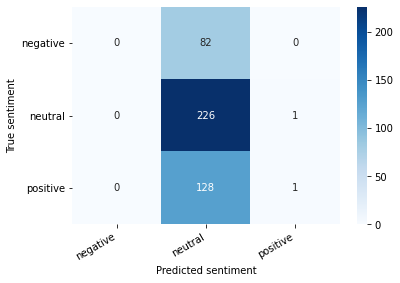

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)